<div style="text-align: center;">
    <h1> <font style="bold"> Analisis Predictivo Avanzado </font></h1>
    <h2><font style="bold">Trabajo práctico </font></h2>
    <h3><font style="bold">Integrantes:</font></h3>
</div>
<div style="display: flex; justify-content: center;">
    <h4><ul>
        <li>Noguera Abril</li>
        <li>Arbues Lucas</li>
        <li>Alfie Agustin</li>
        </ul>
    </h4>
</div>

In [3]:
import pandas as pd
import numpy as np
import gc
import math
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, tpe, space_eval, STATUS_OK
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy import stats
import pycircular
from datetime import datetime
from math import sin, cos, pi
from random import randint, uniform
from xgboost import XGBClassifier
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import xgboost as xgb
from matplotlib import pyplot
import networkx as nx
import zipfile
import os
from unidecode import unidecode

# !pip install -U gensim
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import re

import gensim # Para word2vec.
import logging # Para configurar el monitoreo de gensim.

# Funciones: 
from funciones import encoding, Optimization


In [4]:
# Ruta del archivo ZIP
archivo_zip = 'competition_data.zip'

# Carpeta de destino para extraer los archivos
carpeta_destino = 'archivos_temporales'

# Crear la carpeta de destino si no existe
os.makedirs(carpeta_destino, exist_ok=True)

# Descomprimir el archivo ZIP
with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
    zip_ref.extractall(carpeta_destino)

# Leer el DataFrame desde el archivo CSV
archivo_csv = os.path.join(carpeta_destino, 'competition_data.csv')
df = pd.read_csv(archivo_csv)

# Eliminar el archivo CSV después de leerlo (opcional)
os.remove(archivo_csv)

# Análisis Exploratorio de Datos

In both, the training set and the test set, each row corresponds to a listing's impression at Mercado Libre. That means that the same item will appear many times on the data.

The conversion column contains a boolean that specifies whether an order was attributed to that impression or not. In other words, it tells us if the user who was presented with that listing decided to purchase the item.

In [5]:
df.shape

(199972, 57)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199972 entries, 0 to 199971
Data columns (total 57 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   accepts_mercadopago                199972 non-null  bool   
 1   available_quantity                 199972 non-null  int64  
 2   avg_gmv_item_domain_30days         195607 non-null  float64
 3   avg_gmv_item_sel                   195607 non-null  float64
 4   avg_gmv_seller_bday                195607 non-null  float64
 5   avg_qty_orders_item_domain_30days  195607 non-null  float64
 6   avg_qty_orders_item_sel_30days     195607 non-null  float64
 7   avg_si_item_sel_30day              195607 non-null  float64
 8   benefit                            199971 non-null  float64
 9   boosted                            199972 non-null  bool   
 10  category_id                        199972 non-null  object 
 11  conversion                         1807

### Eliminacion Variables Inutiles

La descripcion del dataset determinaba algunas de las variables como invalidas, estas son:
- benefit
- decimals
- etl_version
- rn

Se eliminan de la base antes de continuar con el analisis.

In [7]:
df = df.drop(['benefit', 'etl_version'], axis=1)

Ademas, la variable total_gmv_domain_bday es una transformacion lineal de la variable total_gmv_domain_30days, por lo que tambien se elimina de la base.

In [8]:
df = df.drop(['total_gmv_domain_bday'], axis=1)

## Análisis de las variables numéricas

Comenzaremos analizando las variables numéricas que podrían no aportarnos valor a la predicción del modelo. 

In [9]:
df_num = df.select_dtypes(include='number')
df_bool = df.select_dtypes(include='bool')

In [10]:
print('\nVariables Numericas:')
for column in df_num:  
  print(column,":\t",df_num[column].nunique()) 


Variables Numericas:
available_quantity :	 6937
avg_gmv_item_domain_30days :	 17727
avg_gmv_item_sel :	 18652
avg_gmv_seller_bday :	 18634
avg_qty_orders_item_domain_30days :	 16760
avg_qty_orders_item_sel_30days :	 15129
avg_si_item_sel_30day :	 15527
conversion :	 2
health :	 35
product_id :	 4440
offset :	 209
original_price :	 6469
price :	 6029
print_position :	 10902
qty_items_dom :	 4193
qty_items_sel :	 1462
sold_quantity :	 5718
total_asp_item_domain_30days :	 17729
total_asp_item_sel_30days :	 18651
total_gmv_item_30days :	 45132
total_items_domain :	 10309
total_items_seller :	 3240
total_orders_domain_30days :	 7882
total_orders_item_30days :	 635
total_orders_sel_30days :	 4413
total_si_domain_30days :	 9157
total_si_item_30days :	 850
total_si_sel_30days :	 5301
total_visits_domain :	 17646
total_visits_item :	 9618
total_visits_seller :	 17762
user_id :	 139110
ROW_ID :	 19211


In [11]:
print('Variables Booleanas:')
for column in df_bool:  
   print(column,":\t",df_bool[column].nunique()) 

Variables Booleanas:
accepts_mercadopago :	 1
boosted :	 1
free_shipping :	 2
fulfillment :	 2


Notamos que las variables *accepts_mercadopago* y *boosted* contienen un unico valor posible. Por lo que lo unico que le aportará al modelo es tiempo computacional, que no queremos!

Por otro lado, las variables *product_id* y *user_id* no las tendremos en cuenta porque en su mayor proporción se encuentran vacias y no aportan información a la predicción. 


In [12]:
df = df.drop(["product_id", "user_id", "accepts_mercadopago", "boosted"], axis=1)

Para finalizar el apartado del analisis de variables numericas, nos gustaria agregar una nueva columna que creemos significativa para predecir la conversión. Notamos que tenemos dos variables *original_price* y *price*. El ratio de las mismas podría encontranse significativas, chequeemos...

In [13]:
df["price_ratio"] = (df["original_price"] - df["price"]) / df["original_price"]

In [14]:
# Analizamos correlación entre logistic_type y conversion
contingency_table = pd.crosstab(df['original_price'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 12282.229450137715
P-value: 0.0


Un valor alto de Chi-cuadrado indica una discrepancia significativa entre las variables. Además, el valor p es 0.0, lo que significa que la probabilidad de obtener un valor de Chi-cuadrado tan alto (o más alto) bajo la suposición de independencia es esencialmente nula. Esto proporciona una fuerte evidencia en contra de la hipótesis nula de independencia y sugiere que las variables están correlacionadas.

### Analisis de Nulos

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199972 entries, 0 to 199971
Data columns (total 51 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   available_quantity                 199972 non-null  int64  
 1   avg_gmv_item_domain_30days         195607 non-null  float64
 2   avg_gmv_item_sel                   195607 non-null  float64
 3   avg_gmv_seller_bday                195607 non-null  float64
 4   avg_qty_orders_item_domain_30days  195607 non-null  float64
 5   avg_qty_orders_item_sel_30days     195607 non-null  float64
 6   avg_si_item_sel_30day              195607 non-null  float64
 7   category_id                        199972 non-null  object 
 8   conversion                         180761 non-null  float64
 9   date                               199972 non-null  object 
 10  deal_print_id                      199972 non-null  object 
 11  domain_id                          1999

Es importante destacar que notamos 4365 registros con muchas columnas nulas en nustro dataset. Algunos de estos registros estan presentes en la base de testing, por eso se decide no hacer estimaciones de estos valores ya que la base de testing es un reflejo de la realidad y no debería ser alterado. 

In [16]:
%%capture
mask = df_num["avg_gmv_item_domain_30days"].isna()
del df_num
df[mask]

Para que el analisis mantenga su consistencia se decide imputar los nulos presentados reemplazandolos por la mediana de la variable con los datos de entrenamiento. 
Las variables sobre las que se hara este proceso son:
- avg_gmv_item_domain_30days         
- avg_gmv_item_sel                  
- avg_gmv_seller_bday                
- avg_qty_orders_item_domain_30days  
- avg_qty_orders_item_sel_30days    
- avg_si_item_sel_30day 
- qty_items_dom                 
- qty_items_sel
- total_asp_item_domain_30days      
- total_asp_item_sel_30days               
- total_gmv_item_30day
- total_orders_domain_30days   
- total_orders_item_30days         
- total_orders_sel_30days      
- total_si_domain_30days         
- total_si_item_30days        
- total_si_sel_30days

In [17]:
# Valores Medios
columnas = ['avg_gmv_item_domain_30days', 'avg_gmv_item_sel','avg_gmv_seller_bday', 'avg_qty_orders_item_domain_30days', 'avg_qty_orders_item_sel_30days',    
            'avg_si_item_sel_30day', 'qty_items_dom', 'qty_items_sel', 'total_asp_item_domain_30days', 'total_asp_item_sel_30days',     
            'total_gmv_item_30days', 'total_orders_domain_30days', 'total_orders_item_30days', 'total_orders_sel_30days',      
            'total_si_domain_30days', 'total_si_item_30days', 'total_si_sel_30days']
for columna in columnas:
    df[columna] = df[columna].fillna(df[df["ROW_ID"].isna()][columna].median()) 

La variable is_pdp tiene nulos, pero se los imputa con un nuevo valor ya que su comportamiento no corresponde al resto:

In [18]:
df['is_pdp'] = df['is_pdp'].astype(str)
df['is_pdp'].fillna('nan', inplace=True)

## Análisis de Variables Categoricas

In [19]:
df_categoricas = df.select_dtypes(include='object')

In [20]:
df_categoricas.columns

Index(['category_id', 'date', 'deal_print_id', 'domain_id', 'full_name',
       'is_pdp', 'item_id', 'listing_type_id', 'logistic_type', 'main_picture',
       'platform', 'print_server_timestamp', 'site_id', 'tags', 'title', 'uid',
       'warranty'],
      dtype='object')

Se eliminan las variables de id que no son representativas:
- deal_print_id: unique id for the print --> 'a9cb2270-5f61-11ea-89fc-13e674cbfad4', '17bfe7b0-7480-11ea-a387-65bd48ab9972', 'b36b3570-79e9-11ea-abe3-5f57eda5c45c' ...
- uid: session id --> 'cb5bfac7-229a-4e3e-96dd-80b2ad3972c1', 'b0f9aa19-00d5-4afd-aa77-45be7c849562', 'fd59890a-f2c2-4282-b2ee-c68f25e20697' ...

In [21]:
df = df.drop(["deal_print_id", "uid"], axis=1)
df_categoricas = df.select_dtypes(include='object')

Se separan las variables temporales:
- date
- print_server_timestamp

In [22]:
df_temporales = df[["date","print_server_timestamp"]]
df_categoricas = df_categoricas.drop(df_temporales, axis=1)

Se separan las variables de texto:
- full_name
- title
- tags

In [23]:
df_text = df[["full_name","title",'tags']]
df_categoricas = df_categoricas.drop(df_text, axis=1)

Para continuar con el analisis notamos que la variable *warranty* es de tipo objeto pero en realidad esta detallando si tiene garantia (cuanto tiempo) o no. Por lo tanto, intentaremos modificar esa variable y analizaremos la garantía de los productos tiene o no una correlación con la conversión. 

Primero se formatea para intentar sacar la mayor cantidad de duplicados:
- Convertir a Minusculas
- Eliminar tildes y caracteres especiales
- Eliminar espacios dobles
- Eliminar espacios al principio y al final de la oración. 

In [24]:
# Eliminar los espacios enfrente y atras de las variables.
df_categoricas['warranty'] = df_categoricas['warranty'].apply(lambda x: x.strip() if isinstance(x, str) else x)
# Le saco las tildes a la base:
df_categoricas['warranty'] = df_categoricas['warranty'].apply(lambda x: unidecode(x) if isinstance(x, str) else x)
# Lo convierto a minusculas
df_categoricas['warranty'] = df_categoricas['warranty'].apply(lambda x: x.lower() if isinstance(x, str) else x)
# Le saco los espacios dobles.
df_categoricas['warranty'] = df_categoricas['warranty'].apply(lambda x: x.replace('  ',' ') if isinstance(x, str) else x)

In [25]:
for valor in df_categoricas['warranty'].dropna().unique():
    print(valor)

garantia de fabrica: 12 meses
garantia de fabrica: 90 dias
garantia del vendedor: 90 dias
6 meses de garantia.
garantia de fabrica: 2 meses
garantia de fabrica: 6 meses
garantia de fabrica: 30 dias
12 meses de garantia, exclusiva del fabricante por fallas de fabrica.
12 meses
garantia del fabricante 12 meses
sin garantia
garantia del vendedor: 15 dias
garantia del vendedor: 180 dias
garantia de fabrica: 60 dias
garantia del vendedor: 6 meses
garantia del vendedor: 1 anos
garantia del vendedor: 12 meses
garantia de la marca.
garantia de fabrica: 1 anos
garantia de fabrica
se ofrece garantia del fabricante y/o importador.
plazos segun especifican en sus politicas y certificados de garantia
mas de 50 anos de trayectoria como fabricantes de ropa interior.
garantia del vendedor: 30 dias
garantia de fabrica: 5 anos
6 meses ante defectos de fabrica
garantia de fabrica: 2 anos
6 meses de garantia cubre defectos de fabricacion otorgada por el importador.
garantia solo por fallas del producto.
g

In [26]:
def categorizar_garantia(garantia):
    garantia = str(garantia)
    if ("fabrica" in garantia) or ('marca' in garantia):
        return "garantia de fabrica"
    elif "vendedor" in garantia:
        return "garantia del vendedor"
    elif "sin garantia" in garantia:
        return "sin garantia"
    elif ('hora' in garantia) or ('hs' in garantia) or ('dia' in garantia) or ('mes'in garantia) or ('ano' in garantia) or ('vida' in garantia) or ('garantizamos' in garantia) or ('gtia' in garantia) or ('garantia' in garantia) or ('si' in garantia):
        return 'garantia'
    else:
        return "sin garantia"

In [27]:
# Aplica la función a la columna "garantia"
df_categoricas["cat_warranty"] = df_categoricas["warranty"].apply(categorizar_garantia)

In [28]:
df_categoricas["cat_warranty"].value_counts()

cat_warranty
garantia de fabrica      77399
sin garantia             72952
garantia del vendedor    37228
garantia                 12393
Name: count, dtype: int64

Analicemos la correlación de la variable *warranty* con la variable *conversion*

In [29]:
# Analizamos correlación entre logistic_type y conversion
contingency_table = pd.crosstab(df_categoricas['cat_warranty'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 126.2365510005184
P-value: 3.499566183925306e-27


A partir de el analisis de correlación (Chi cuadrado) notamos que existe una asociación significativa entre las dos variables categóricas. Por lo que la utilizaremos en el modelo para estimar la probabilidad de conversion. 

La variable main_picture no es representativa para el analisis, que este vacia no determina que tenga o no imagen. Todos los productos listados en mercado libre deben contener imagen.

In [30]:
df = df.drop('main_picture', axis =1)

La variable platform se puede dividir ademas en si el usuario esta desde la web o mobile.

In [31]:
df['platform'].unique()

array(['/web/desktop', '/mobile/android', '/web/mobile', '/mobile/ios'],
      dtype=object)

In [32]:
df_categoricas['platform_web'] = df_categoricas['platform'].str.contains('web', case=False)

In [33]:
for column in df_categoricas:  
   print(column,":\t",df_categoricas[column].nunique()) 

category_id :	 2284
domain_id :	 1742
is_pdp :	 3


item_id :	 27695
listing_type_id :	 2
logistic_type :	 7
main_picture :	 26961
platform :	 4
site_id :	 1
warranty :	 1059
cat_warranty :	 4
platform_web :	 2


Se elimina la variable porque solo tiene una categorica:
- site_id

In [34]:
df = df.drop('site_id', axis=1)

Se cree que el tipo de logistica no tiene una relacion natural con la variable resultado. Uno no decide si hacer una compra o no segun el tipo de logistica que utilice el comerciante para transportar su producto. Pero se procede a evaluar si existe una correlacion empirica. En caso de no haberla, se descartara la variable del analisis. 

In [35]:
# Analizamos correlación entre logistic_type y conversion
contingency_table = pd.crosstab(df['logistic_type'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 761.455399863375
P-value: 3.269950268794381e-161


## Análisis de Variables de Texto

In [36]:
df_text.columns

Index(['full_name', 'title', 'tags'], dtype='object')

In [37]:
# Eliminar los espacios enfrente y atras de las variables.
df_text = df_text.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# Le saco las tildes a la base:
df_text = df_text.applymap(lambda x: unidecode(x) if isinstance(x, str) else x)
# Lo convierto a minusculas
df_text = df_text.applymap(lambda x: x.lower() if isinstance(x, str) else x)
# Le saco los espacios dobles.
df_text = df_text.applymap(lambda x: x.replace('  ',' ') if isinstance(x, str) else x)

En el caso de full name se extrae la primer categoria:

In [38]:
df_text['name'] = df['full_name'].str.split('-', n=1).str[0]

In [39]:
df_text['name'].nunique()

32

Como son 32 clases, se podria realizar un Encoding sobre esta variable.

In [40]:
# Analizamos correlación entre name y conversion
contingency_table = pd.crosstab(df_text['name'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 2091.2717780728476
P-value: 0.0


In [41]:
df_categoricas['name'] = df_text['name']

In [42]:
# Eliminar las llaves
df_text['tags'] = df_text['tags'].str.replace('[\[\]]', '', regex=True)

In [43]:
# Dividir las etiquetas en listas y luego codificarlas en variables binarias
tags_encoded = df_text['tags'].str.get_dummies(sep=', ')

# Agregar las variables binarias al DataFrame original
df_text = pd.concat([df_text, tags_encoded], axis=1)

Agregamos las nuevas columnas a df:

In [44]:
df = pd.concat([df,df_categoricas[["cat_warranty", "platform_web", "name"]], tags_encoded], axis=1)

In [45]:
df = df.drop(['warranty','tags','full_name','title'], axis = 1) 

## Análisis de Variables Temporales

Las variables temporales pueden influir mucho en el comportamiento del consumidor. Se debe evaluar y tener en cuenta el momento en el que estan visitando la pagina ya que puede determinar si se realiza o no la conversion. Es por eso que se realiza un encoding de estas variables.

In [46]:
# Modificamos el tipo de datos a datetime.
df["date"] = pd.to_datetime(df["date"])
df["print_server_timestamp"] = pd.to_datetime(df["print_server_timestamp"])
df[["date","print_server_timestamp"]]

,date,print_server_timestamp
0,2020-03-06,2020-03-06 00:19:30.735000-04:00
1,2020-04-01,2020-04-01 21:20:11.738000-04:00
2,2020-04-08,2020-04-08 18:38:48.360000-04:00
3,2020-04-25,2020-04-25 22:01:19.829000-04:00
4,2020-03-10,2020-03-10 13:20:56.633000-04:00
...,...,...
199967,2020-04-12,2020-04-12 14:35:44.784000-04:00
199968,2020-04-03,2020-04-03 17:32:53.035000-04:00
199969,2020-04-01,2020-04-01 22:51:08.898000-04:00
199970,2020-04-08,2020-04-08 11:32:27.563000-04:00


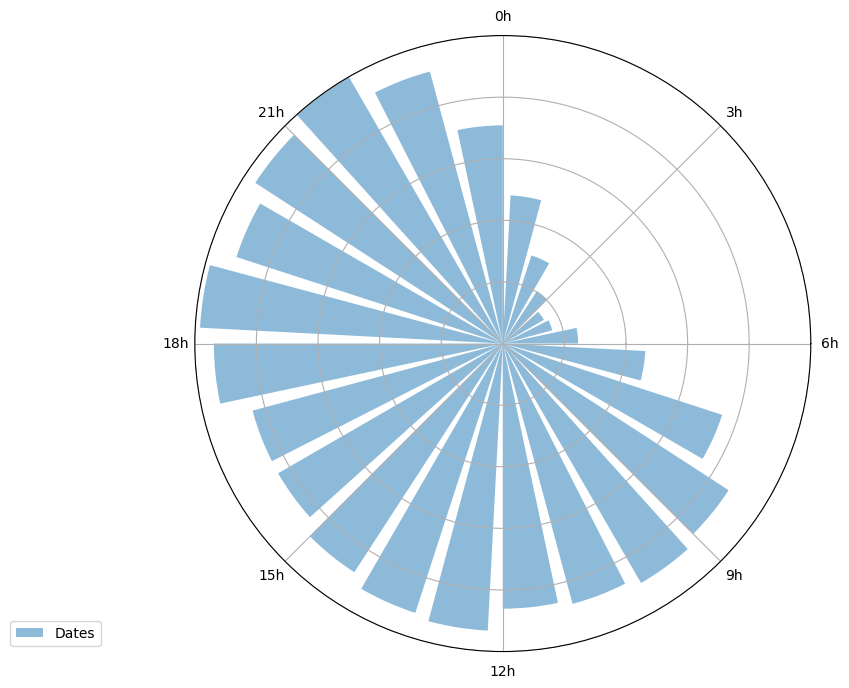

In [47]:
time_segment = 'hour'  
freq_arr, times = pycircular.utils.freq_time(df["print_server_timestamp"] , time_segment=time_segment)
fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

Combinando las funciones seno y coseno podemos caracterizar una variable cíclica. Esto se simula de esta manera para que las variables tengan un sentido ciclico y no lineal. Por ejemplo, en el caso de las horas la hora 00 y la hora 23 en la realidad estan muy cerca una de la otra. Si se las analiza linealmente perderian esta propiedad, pero si se les hace un encoding calculando sus seno y coseno se mantendria. 
Se realizara este analisis con las horas, los dias de la semana y los dias del mes.
No se realiza sobre el mes porque solo hay dos meses.

Para las horas:

In [48]:
# Unidad de tiempo:
cantidad_tiempo = 24

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.hour*(2*math.pi/cantidad_tiempo)))
coseno = np.cos((df["print_server_timestamp"].dt.hour*(2*math.pi/cantidad_tiempo)))

df['hour_sin'] = seno
df['hour_cos'] = coseno


Para los dias de la semana:

In [49]:
# Unidad de tiempo:
cantidad_tiempo = 7

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.weekday*(2*math.pi/cantidad_tiempo)))
coseno = np.cos((df["print_server_timestamp"].dt.weekday*(2*math.pi/cantidad_tiempo)))

df['weekday_sin'] = seno
df['weekday_cos'] = coseno

Para los dias del mes:

In [50]:
# Como solo hay mes 3 y 4 aplicamos una regla para determinar la cantidad de dias en cada uno de los meses:
df["days_in_month"] = df["print_server_timestamp"].dt.month.apply(lambda x: 31 if x == 3 else 30)

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.day*(2*math.pi/df["days_in_month"])))
coseno = np.cos((df["print_server_timestamp"].dt.day*(2*math.pi/df["days_in_month"])))

df['day_sin'] = seno
df['day_cos'] = coseno

df = df.drop(columns = ["days_in_month"])


In [51]:
df = df.drop(columns = ["date","print_server_timestamp"])

## Encoding:

Procedemos a analizar las variables categoricas: 

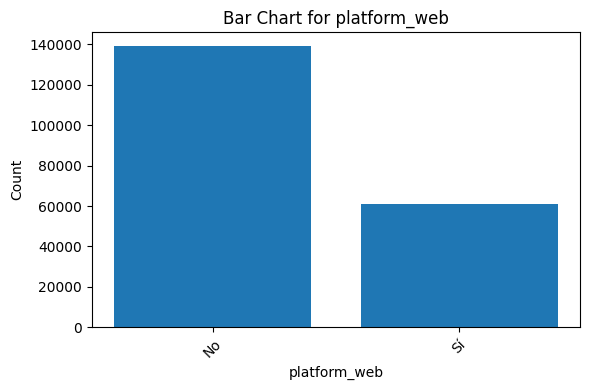

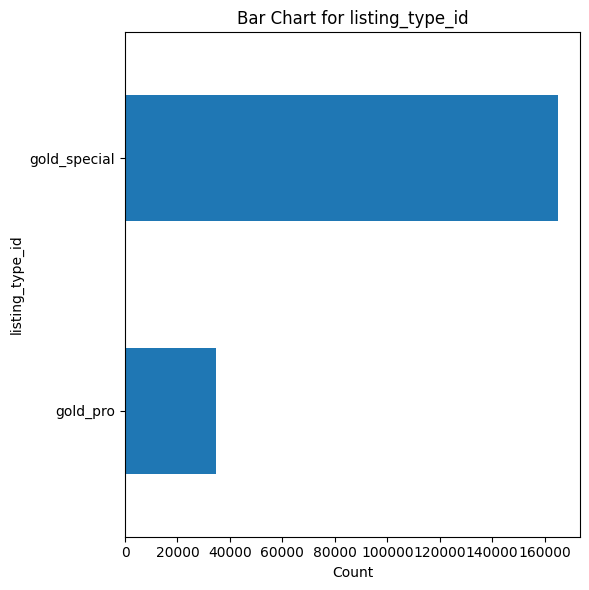

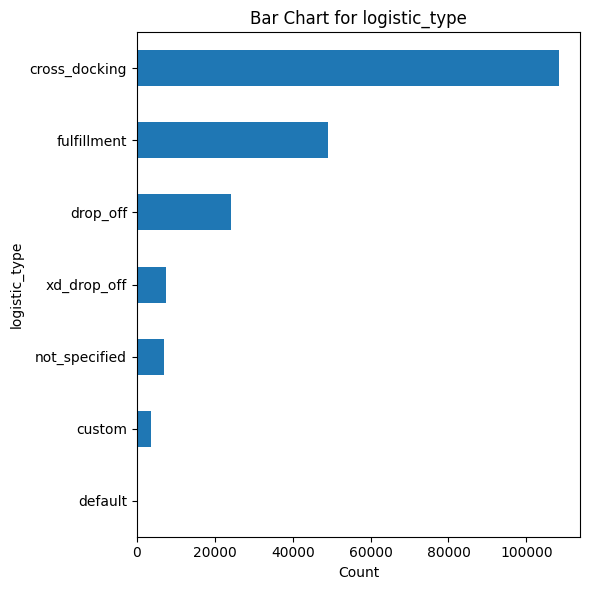

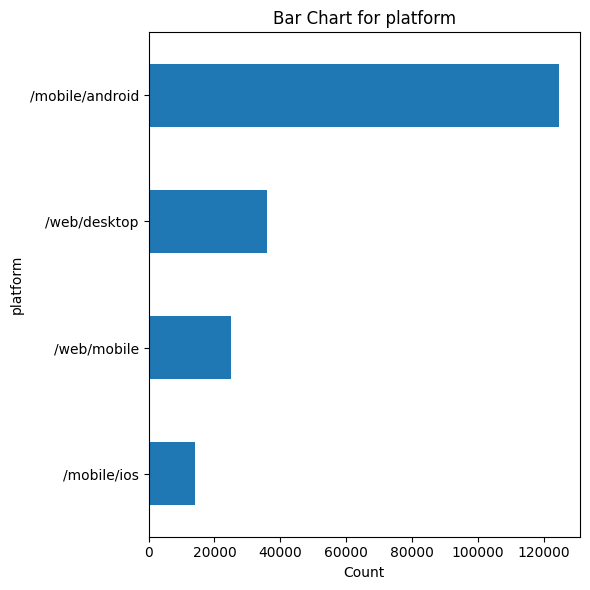

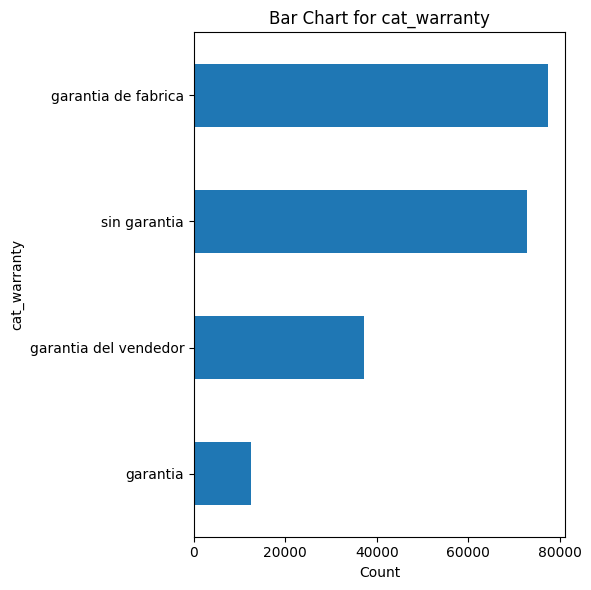

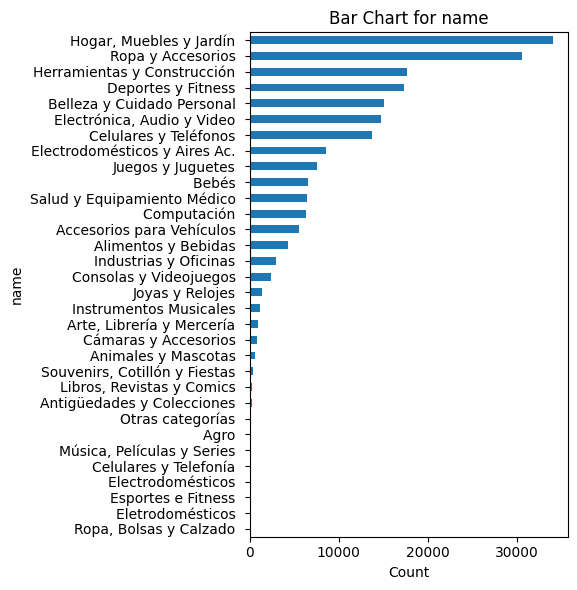

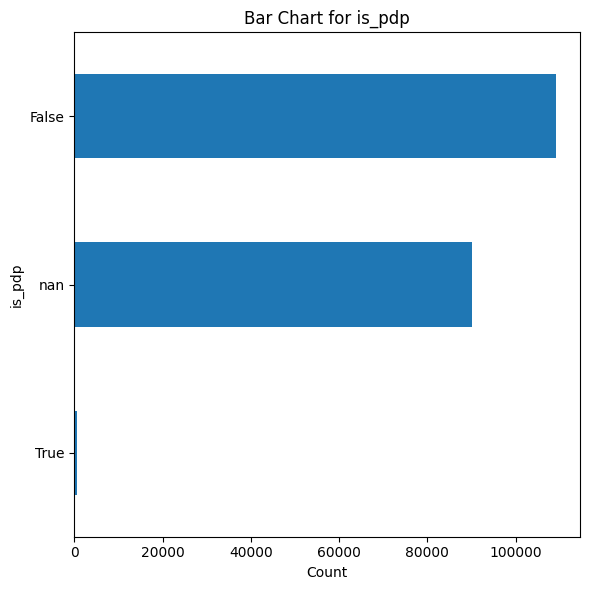

In [52]:
# Iterar a través de las columnas categóricas y crear un gráfico de barras para cada una
for column in df_categoricas[['platform_web']]:  
    categories = df_categoricas[column].value_counts().index
    values = df_categoricas[column].value_counts().values
    

    plt.figure(figsize=(6, 4))  # Tamaño del gráfico (opcional)
    plt.bar(categories, values)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Bar Chart for {column}')
    plt.xticks(rotation=45)  # Rotar etiquetas si son largas
    plt.xticks([0, 1], ['No', 'Sí']) 
    plt.tight_layout()  # Ajustar el diseño
    plt.show()

# Iterar a través de las columnas categóricas y crear un gráfico de barras para cada una
for column in df_categoricas[["listing_type_id","logistic_type", "platform",'cat_warranty','name', 'is_pdp']]:  
    # Cuenta la frecuencia de cada especie y ordena de mayor a menor
    frecuencia = df_categoricas[column].value_counts().sort_values(ascending=True)

    # Crea un gráfico de barras horizontal
    plt.figure(figsize=(6, 6))  # Ajusta el tamaño si es necesario
    frecuencia.plot(kind='barh')  # Usa 'barh' para gráfico de barras horizontal
    plt.xlabel('Count')
    plt.title(f'Bar Chart for {column}')
    plt.tight_layout()
    plt.show()



Como resulta significativa la prueba de chi-cuadrado, se concluye que la variable logistic_type presenta una correlacion empirica. Es por eso que se decide hacer OneHotEncoding con la misma.


Realizamos distintas tecnicas de Encoding en las variables categoricas. El tipo de codificación a aplicar ('OHE', 'LE', 'OE', 'FE', 'TE').

Las variables booleanas ya tienen Encoding.
- picture
- platform_web

En el resto de variabels categoricas se evalua que tipo de encoding es el mas eficiente:
- category_id
- domain_id
- item_id
- name
- listing_type_id
- logistic_type
- platform
- cat_warranty

In [53]:
## HACER PIPELINE PROBANDO LOS DISTINTOS ENCODINGS. 
dfOHE =  pd.concat([encoding(df[['category_id', 'domain_id', 'item_id','name','conversion']], ['category_id', 'domain_id', 'item_id','name'], 'TE'),
                    encoding(df.drop(['category_id', 'domain_id', 'item_id','name','conversion'], axis=1), ['listing_type_id', 'logistic_type', 'platform', 'cat_warranty', 'is_pdp'], 'OHE')], axis=1)
dfLE = encoding(df, ['category_id', 'domain_id', 'item_id','name', 'listing_type_id', 'logistic_type', 'platform', 'cat_warranty', 'is_pdp'], 'LE')
dfOE = encoding(df, ['category_id', 'domain_id', 'item_id','name', 'listing_type_id', 'logistic_type', 'platform', 'cat_warranty', 'is_pdp'], 'OE')
dfFE = encoding(df, ['category_id', 'domain_id', 'item_id','name', 'listing_type_id', 'logistic_type', 'platform', 'cat_warranty', 'is_pdp'], 'FE')
dfTE = encoding(df, ['category_id', 'domain_id', 'item_id','name', 'listing_type_id', 'logistic_type', 'platform', 'cat_warranty', 'is_pdp'], 'TE')

# Exploración e Implementación del Modelo 

Una vez finalizado el analisis exploratorio de datos (EDA), se procede a la exploracion e implementacion del modelo.

- Train: 80%
- Val: 20%
- Test: de testeo.

In [54]:
df = dfOHE

In [55]:
# Split into training and evaluation samples
train_data = df[df["ROW_ID"].isna()]
test_data = df[df["ROW_ID"].notna()]
del(df)

In [56]:
# train_data = train_data.select_dtypes(include='number')
train_data = train_data.drop(columns=["ROW_ID"])
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=["conversion"]), train_data['conversion'], test_size=0.2)
del train_data

In [57]:
X_test = test_data.drop(columns=["conversion", "ROW_ID"])
# X_test = X_test.select_dtypes(include='number')

## Optimización

In [70]:
from funciones import Optimization

In [71]:
model = XGBClassifier(n_jobs=-1, use_label_encoder=False)

/Users/anoguera/anaconda3/envs/itba_apa_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [72]:
grid = {'max_depth': stats.randint(1,20),
              'learning_rate': stats.uniform(0.01, 0.5),
              'subsample': stats.uniform(0.1, 1),
              'colsample_bytree': stats.uniform(0.1, 1),
              'min_child_weight': stats.randint(1,4),
              'n_estimators': stats.randint(50, 1000)
             }

In [63]:
search_spaces = {
    'n_estimators': (10, 200),
    'max_depth': (1, 32),
    'min_samples_split': (2, 20),
}

### Random Search:

In [60]:
optimizer = Optimization(model=model, param_grid=grid, n_iter=10, cv=5, random_state=42)

NameError: name 'model' is not defined

In [ ]:
%%capture
RS = optimizer.random_search(X_train, y_train)

In [62]:
best_params_random = RS.best_params_
print("Best hyperparameters (Random Search):", best_params_random)

Best hyperparameters (Random Search): {'colsample_bytree': 0.2559945203362026, 'learning_rate': 0.03904180608409973, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 711, 'subsample': 0.15641157902710026}


In [63]:
RS.best_score_

0.9146451081262097

In [65]:
# Predict on the evaluation set
y_pred = RS.predict_proba(X_test)[:,1]
y_pred

array([9.4744709e-04, 4.4280605e-05, 9.1002462e-03, ..., 1.2622554e-04,
       7.1937880e-03, 1.8981107e-05], dtype=float32)

In [66]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xg_boostRS.csv", sep=",", index=False)

### Bayesian Search:

In [64]:
optimizer = Optimization(model=model, param_grid=grid, n_iter=10, cv=5, random_state=42, bayes_search=True)

In [65]:
%%capture
BS = optimizer.bayesian_optimization(X_train, y_train, search_spaces)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
best_params_bayes = BS.best_params_
print("Best hyperparameters (Bayes Search):", best_params_bayes)

Best hyperparameters (Random Search): {'colsample_bytree': 0.2559945203362026, 'learning_rate': 0.03904180608409973, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 711, 'subsample': 0.15641157902710026}


In [ ]:
BS.best_score_

<bound method ClassifierMixin.score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)>

In [ ]:
# Predict on the evaluation set
y_pred = model.predict_proba(X_test)[:,1]
y_pred

In [ ]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xg_boostBS.csv", sep=",", index=False)

### Optuna:

In [68]:
optimizer = Optimization(model=model, param_grid=search_spaces, n_iter=10, cv=5, random_state=42, optuna_search=True)

In [69]:
%%capture
O = optimizer.optuna_optimization(X_train, y_train, n_trials=100)

[I 2023-10-01 09:02:16,131] A new study created in memory with name: no-name-81ba3261-f0e6-4826-a5e4-b0b9ef084f33
[W 2023-10-01 09:02:16,133] Trial 0 failed with parameters: {} because of the following error: ValueError("Unsupported parameter type: <class 'tuple'>").
Traceback (most recent call last):
  File "/Users/anoguera/anaconda3/envs/itba_apa_env/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/Users/anoguera/Documents/GitHub/TrabajoAPA/funciones.py", line 175, in objective
    raise ValueError(f"Unsupported parameter type: {type(value)}")
ValueError: Unsupported parameter type: <class 'tuple'>
[W 2023-10-01 09:02:16,134] Trial 0 failed with value None.


ValueError: Unsupported parameter type: <class 'tuple'>

In [ ]:
best_params_optuna = O.best_params_
print("Best hyperparameters (Optuna Optimization):", best_params_optuna)

Best hyperparameters (Random Search): {'colsample_bytree': 0.2559945203362026, 'learning_rate': 0.03904180608409973, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 711, 'subsample': 0.15641157902710026}


In [ ]:
O.best_score_

<bound method ClassifierMixin.score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)>

In [ ]:
# Predict on the evaluation set
y_pred = model.predict_proba(X_test)[:,1]
y_pred

In [ ]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xg_boostO.csv", sep=",", index=False)

### Prueba 1

Se realiza una primera prueba haciendo un unico job, pocas iteraciones y pocos splits en el cross validation con el fin de que demore poco y ver la performance rapidamente:

In [633]:
%%capture
model_xgb_1 = XGBClassifier(n_jobs=-1, use_label_encoder=False)

In [634]:
%%capture
param_dist_1 = {'max_depth': stats.randint(1,20),
              'learning_rate': stats.uniform(0.01, 0.5),
              'subsample': stats.uniform(0.1, 1),
              'colsample_bytree': stats.uniform(0.1, 1),
              'min_child_weight': stats.randint(1,4),
              'n_estimators': stats.randint(50, 1000)
             }
# Cross Validation
cv = StratifiedKFold(n_splits=3, random_state=41, shuffle=True)

xgb_random_1 = RandomizedSearchCV(model_xgb_1,param_dist_1, cv=cv, verbose=1, n_jobs=-1,scoring='roc_auc',n_iter=10,random_state=41)
xgb_random_1.fit(X_train,y_train)

Los siguientes parametros fueron los que mejor performance le dieron al modelo:

In [635]:
xgb_random_1.best_params_

{'colsample_bytree': 0.797341005303125,
 'learning_rate': 0.0648294133827315,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 222,
 'subsample': 0.7230957216262662}

El siguiente valor representa la performance del modelo (con un unico job):

In [636]:
xgb_random_1.best_score_ # 0.8906081858749014

0.8906081858749014

In [637]:
# Predict on the evaluation set
y_pred_1 = xgb_random_1.predict_proba(X_test)[:,1]
y_pred_1

array([2.8590651e-02, 1.2271752e-04, 1.6154565e-01, ..., 8.2220002e-05,
       9.0369016e-02, 6.8040797e-05], dtype=float32)

In [640]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_1})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xg_boost.1.csv", sep=",", index=False)

<Figure size 1200x3000 with 0 Axes>

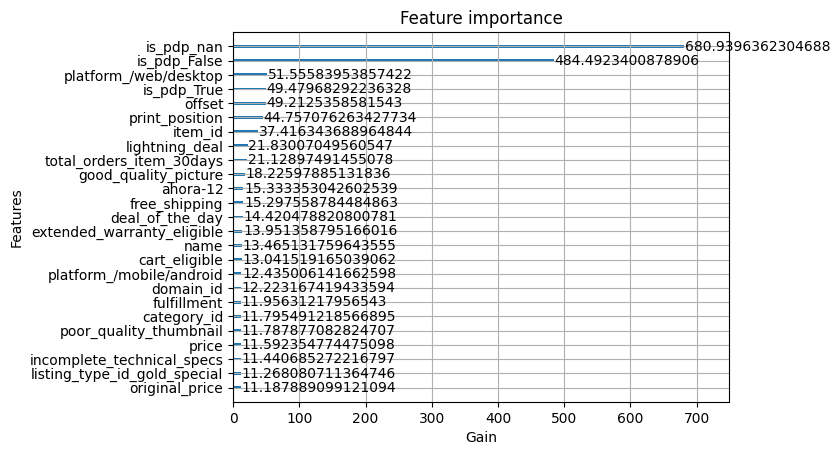

In [639]:
# Obtener el mejor modelo entrenado de tu RandomizedSearchCV
best_model_xgb_1 = xgb_random_1.best_estimator_

# Ajustar el tamaño del gráfico utilizando figsize
plt.figure(figsize=(12, 30))   # Ajusta el tamaño según tus preferencias

# Generar el gráfico de importancia
xgb.plot_importance(best_model_xgb_1, max_num_features=25,  importance_type="gain", xlabel="Gain")

# Mostrar el gráfico
plt.show()

### Prueba 2: 


In [ ]:
%%capture
model_xgb_2 = XGBClassifier(n_jobs=3, use_label_encoder=False)

In [ ]:
%%capture
param_dist_2 = {'max_depth': stats.randint(5,12),
              'learning_rate': stats.uniform(0.05, 0.5),
              'subsample': stats.uniform(0.1, 1),
              'colsample_bytree': stats.uniform(0.1, 1),
              'min_child_weight': stats.randint(1,4),
              'n_estimators': stats.randint(50, 1000)
             }
cv = StratifiedKFold(n_splits=3, random_state=41, shuffle=True)

xgb_random_2 = RandomizedSearchCV(model_xgb_2,param_dist_2, cv=cv, verbose=1, n_jobs=3,scoring='roc_auc',n_iter=40,random_state=15)
xgb_random_2.fit(X_train,y_train)

In [ ]:
xgb_random_2.best_params_
# {'colsample_bytree': 0.6132378121429716,
#  'learning_rate': 0.033917082477347975,
#  'max_depth': 7,
#  'min_child_weight': 3,
#  'n_estimators': 515,
#  'subsample': 0.8452823549192477}

# {'colsample_bytree': 0.6011204636599379,
#  'learning_rate': 0.08602556667988077,
#  'max_depth': 7,
#  'min_child_weight': 1,
#  'n_estimators': 217,
#  'subsample': 0.6277647948207705}

{'colsample_bytree': 0.1664474589125239,
 'learning_rate': 0.09192844711931981,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 229,
 'subsample': 0.9278123360964413}

In [ ]:
xgb_random_2.best_score_
# 0.8863150973378336

0.887388988810604

Iteraciones de el modelo que mejor performance tuvo:

In [ ]:
for i, score in enumerate(xgb_random_2.cv_results_['mean_test_score']):
    print(f"Iteraciones {i+1}: auc_roc = {score:.4f}")

Iteraciones 1: auc_roc = 0.8815
Iteraciones 2: auc_roc = 0.8707
Iteraciones 3: auc_roc = nan
Iteraciones 4: auc_roc = 0.8570
Iteraciones 5: auc_roc = 0.8629
Iteraciones 6: auc_roc = 0.8385
Iteraciones 7: auc_roc = 0.8796
Iteraciones 8: auc_roc = 0.8669
Iteraciones 9: auc_roc = 0.8250
Iteraciones 10: auc_roc = 0.8865
Iteraciones 11: auc_roc = 0.8817
Iteraciones 12: auc_roc = 0.8335
Iteraciones 13: auc_roc = 0.8301
Iteraciones 14: auc_roc = 0.8731
Iteraciones 15: auc_roc = 0.8714
Iteraciones 16: auc_roc = 0.8775
Iteraciones 17: auc_roc = 0.8584
Iteraciones 18: auc_roc = 0.8581
Iteraciones 19: auc_roc = 0.8278
Iteraciones 20: auc_roc = 0.8749
Iteraciones 21: auc_roc = nan
Iteraciones 22: auc_roc = nan
Iteraciones 23: auc_roc = 0.8755
Iteraciones 24: auc_roc = 0.8756
Iteraciones 25: auc_roc = 0.8623
Iteraciones 26: auc_roc = 0.8736
Iteraciones 27: auc_roc = 0.8636
Iteraciones 28: auc_roc = 0.8723
Iteraciones 29: auc_roc = 0.8783
Iteraciones 30: auc_roc = nan
Iteraciones 31: auc_roc = nan
I

In [ ]:
# Predict on the evaluation set
y_pred_2 = xgb_random_2.predict_proba(X_test)[:,1]
y_pred_2

array([0.02958968, 0.00273408, 0.08706857, ..., 0.00997374, 0.12048792,
       0.00163524], dtype=float32)

In [ ]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_2})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xg_boost.2.csv", sep=",", index=False)

#### Importancia de Variables

<Figure size 1200x3000 with 0 Axes>

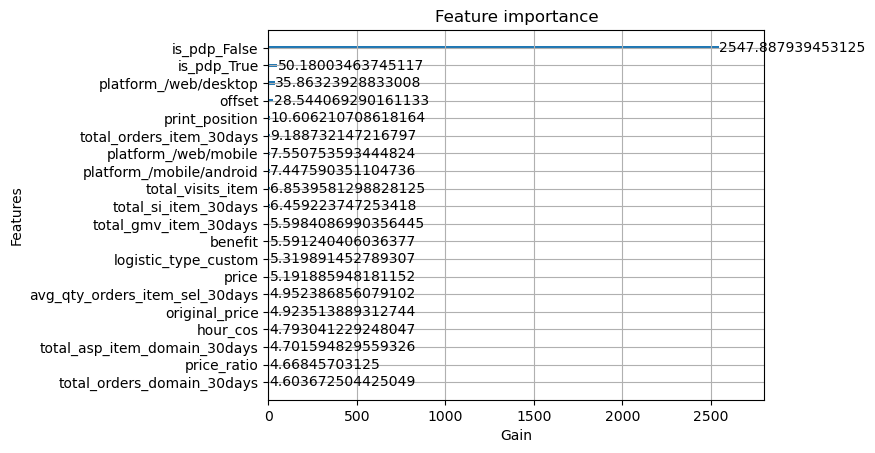

In [ ]:

# Obtener el mejor modelo entrenado de tu RandomizedSearchCV
best_model_xgb = xgb_random_2.best_estimator_

# Ajustar el tamaño del gráfico utilizando figsize
plt.figure(figsize=(12, 30))   # Ajusta el tamaño según tus preferencias

# Generar el gráfico de importancia
xgb.plot_importance(best_model_xgb, max_num_features=20,  importance_type="gain", xlabel="Gain")

# Mostrar el gráfico
plt.show()

<span style="color:red">La performance del modelo con el 30% de los datos de test (public kaggle competition) dio como resultado: 0.88696</span>

### Prueba 3:

 Ahora utilicemos *early_stopping_rounds* a modo de que el modelo frene luego de que pasen 10 iteraciones en la que la performance no mejora. Este nos ayudará a intentar omitir el overfitting. 

In [ ]:
%%capture
model_xgb_3 = XGBClassifier(n_jobs=3, use_label_encoder=False, early_stopping_rounds=10)

In [ ]:
%%capture
# Definir la grilla de parámetros
param_grid = {
    'max_depth': [5, 6, 7], 
    'learning_rate': np.arange(0.05, 0.1),  
    # 'subsample': np.arange(0.1, 1.1), 
    # 'colsample_bytree': np.arange(0.3, 0.91, 0.1), 
    'min_child_weight': [2, 3], 
    'n_estimators': [400, 500, 800, 1000]  
}

# Crear una instancia de StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

# Crear una instancia de GridSearchCV con tu modelo
grid_search = GridSearchCV(model_xgb_3, param_grid, cv=cv, verbose=1, scoring='roc_auc')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train, y_train)

NameError: name 'GridSearchCV' is not defined

In [ ]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 800}

In [ ]:
grid_search.best_score_

0.8948503248079724

In [ ]:
# Print the accuracy for each iteration
for i, score in enumerate(grid_search.cv_results_['mean_test_score']):
    print(f"Iteraciones {i+1}: roc_auc = {score:.4f}")

Iteraciones 1: roc_auc = 0.8924
Iteraciones 2: roc_auc = 0.8932
Iteraciones 3: roc_auc = 0.8943
Iteraciones 4: roc_auc = 0.8946
Iteraciones 5: roc_auc = 0.8925
Iteraciones 6: roc_auc = 0.8934
Iteraciones 7: roc_auc = 0.8944
Iteraciones 8: roc_auc = 0.8948
Iteraciones 9: roc_auc = 0.8935
Iteraciones 10: roc_auc = 0.8941
Iteraciones 11: roc_auc = 0.8949
Iteraciones 12: roc_auc = 0.8947
Iteraciones 13: roc_auc = 0.8937
Iteraciones 14: roc_auc = 0.8942
Iteraciones 15: roc_auc = 0.8945
Iteraciones 16: roc_auc = 0.8944
Iteraciones 17: roc_auc = 0.8946
Iteraciones 18: roc_auc = 0.8948
Iteraciones 19: roc_auc = 0.8944
Iteraciones 20: roc_auc = 0.8941
Iteraciones 21: roc_auc = 0.8943
Iteraciones 22: roc_auc = 0.8946
Iteraciones 23: roc_auc = 0.8943
Iteraciones 24: roc_auc = 0.8939


In [ ]:
# Predict on the evaluation set
y_pred_3 = grid_search.predict_proba(X_test)[:,1]
y_pred_3

array([3.5815734e-02, 3.6029403e-05, 9.6014962e-02, ..., 5.1810421e-05,
       1.7267054e-01, 3.0102408e-05], dtype=float32)

In [ ]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 800}

In [ ]:
grid_search.best_score_

0.8948503248079724

In [ ]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_3})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xg_boost.3.csv", sep=",", index=False)

#### Grafico de performance

In [ ]:
# Suponiendo que grid_search es tu objeto GridSearchCV ya entrenado

best_model = grid_search.best_estimator_  # Obtener el mejor modelo

# Entrenar el mejor modelo individualmente para obtener el historial de métricas
evals = [(X_train, y_train), (X_test, y_test)]  # Puedes ajustar esto a tus datos
best_model.fit(X_train, y_train, eval_metric="auc", eval_set=evals, verbose=True)

# Obtener el historial de métricas
train_history = best_model.evals_result()
epochs = len(train_history['validation_0']['auc'])
iterations = range(0, epochs)

# Ahora puedes trazar el historial de AUC-ROC
plt.plot(iterations, train_history["validation_0"]["auc"], label="training data")
plt.plot(iterations, train_history["validation_1"]["auc"], label="validation data")
plt.legend()
plt.ylabel('auc_roc')
plt.title('XGBoost auc_roc')
plt.show()


NameError: name 'y_test' is not defined

#### Importancia de Variables

<Figure size 1200x3000 with 0 Axes>

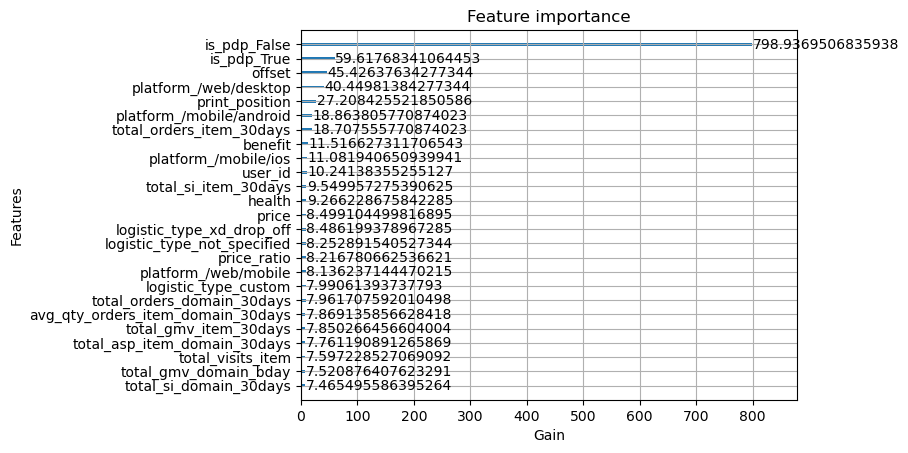

In [ ]:

# Obtener el mejor modelo entrenado de tu RandomizedSearchCV
best_model_xgb = xgb_random_2.best_estimator_

# Ajustar el tamaño del gráfico utilizando figsize
plt.figure(figsize=(12, 30))   # Ajusta el tamaño según tus preferencias

# Generar el gráfico de importancia
xgb.plot_importance(best_model_xgb, max_num_features=25,  importance_type="gain", xlabel="Gain")

# Mostrar el gráfico
plt.show()

### Prueba 4

In [ ]:
xgb1_fijo = xgb.XGBClassifier(
    objective = 'binary:logistic',
    random_state = 41,
    n_jobs=-1,
    colsample_bytree = 0.6132378121429716,
    learning_rate = 0.1,
    max_depth =7,
    min_child_weight = 3,
    n_estimators= 515,
    subsample= 0.8452823549192477
)

In [ ]:
%%capture
xgb1_fijo.fit(X_train, y_train, early_stopping_rounds=15, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='auc', verbose=True)


Text(0.5, 1.0, 'XGBoost auc_roc')

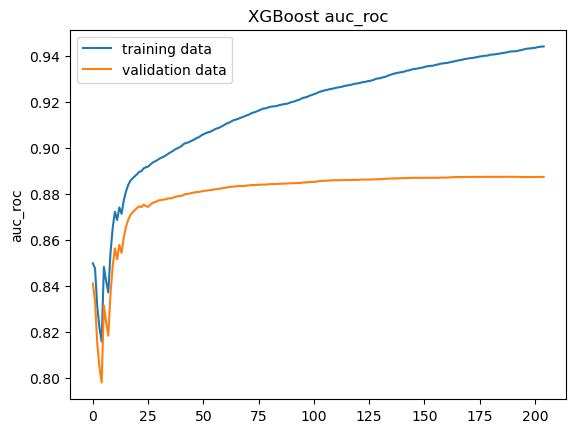

In [ ]:
train_history = xgb1_fijo.evals_result()
epochs = len(train_history['validation_0']['auc'])
iterations = range(0, epochs)
plt.plot(iterations, train_history["validation_0"]["auc"], label="training data")
plt.plot(iterations, train_history["validation_1"]["auc"], label="validation data")
plt.legend()
pyplot.ylabel('auc_roc')
pyplot.title('XGBoost auc_roc')

In [ ]:
xgb1_fijo.best_score

0.8875425758670876

In [ ]:
# Predict on the evaluation set
y_pred_4 = xgb1_fijo.predict_proba(X_test)[:,1]
y_pred_4

array([3.77924815e-02, 1.10463814e-04, 1.09536245e-01, ...,
       1.54589477e-04, 7.89746717e-02, 4.79183182e-05], dtype=float32)

In [ ]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_4})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xgb1_fijo.csv", sep=",", index=False)